In [25]:
#kaggle API token
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

# **1 Import required libraries**

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import joblib
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, MaxPool1D

%load_ext tensorboard
from keras.callbacks import TensorBoard

# **2 Load data**

**Load train Data**

In [2]:
train_LTB = joblib.load('/content/drive/MyDrive/applied aic/case studies/rcaf/train_data/train_LTB_standardized.pkl')

In [ ]:
train_LTB

,filtered_ecg_signal,filtered_gsr_signal,filtered_respiration_signal,eeg_fp1-f7,eeg_f7-t3,eeg_t3-t5,eeg_t5-o1,eeg_fp1-f3,eeg_f3-c3,eeg_c3-p3,eeg_p3-o1,eeg_t3-c3,eeg_c3-cz,eeg_cz-c4,eeg_c4-t4,eeg_fp2-f8,eeg_f8-t4,eeg_t4-t6,eeg_t6-o2,eeg_fp2-f4,eeg_f4-c4,eeg_c4-p4,eeg_p4-o2,event
0,0.000017,0.002526,-0.000506,-0.990796,0.062082,-0.461029,0.167230,-0.537239,-0.075824,-0.451149,-0.186699,0.154520,1.369372,-2.241728,2.086796,0.013534,0.077024,-1.398095,0.107120,-0.244838,-0.914358,1.705960,0.160260,0
1,0.000017,0.002526,-0.000506,-0.956225,0.201983,-0.434192,0.141678,-0.520903,-0.041812,-0.307931,-0.107912,0.002200,1.115051,-1.616374,1.446252,0.014096,-0.242997,-0.934474,-0.073186,-0.320875,-0.646735,0.994528,0.090173,0
2,0.000017,0.002526,-0.000506,-0.636657,0.123888,-0.310765,0.149698,-0.305796,-0.000149,-0.474425,-0.054708,0.150501,1.162661,0.746872,-1.566992,-0.578305,-0.380939,0.406826,-0.268486,-0.305182,0.632106,-2.769991,-0.156141,0
3,0.000017,0.002526,-0.000506,-0.475835,0.171364,-0.566492,0.034061,-0.223810,-0.003538,-0.516215,-0.270948,0.008826,0.933483,-0.864222,0.236726,-0.165307,-0.402901,-0.384556,0.076603,-0.283559,-0.202307,-0.431194,0.227463,0
4,0.000016,0.002526,-0.000506,-0.605326,0.136157,-0.377437,-0.104362,-0.284636,-0.060104,-0.511513,-0.277651,0.029641,1.034743,-0.255650,0.011602,-0.145140,-0.245467,-0.667188,-0.127322,-0.248356,0.022255,-1.443984,-0.003291,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867416,-0.394661,-2.130485,-0.138419,0.601303,-1.468751,-0.225165,0.043749,-0.406079,-0.381982,-0.765261,0.567929,-0.420419,0.629352,0.718721,-0.318943,-0.232573,-0.190880,1.211385,-1.545929,-0.109309,0.015374,-1.841067,0.267008,0
4867417,-0.383370,-2.130562,-0.138443,-3.069250,1.763412,1.697806,-0.380365,1.604349,-5.500784,10.657767,-0.015044,-3.586099,5.300180,-7.208307,6.281775,1.063037,-1.458277,-1.486740,0.715306,-1.185666,-2.561664,11.617146,0.033155,0
4867418,-0.372039,-2.130638,-0.138468,0.646365,-1.528798,-0.142058,-0.207044,-0.493910,-0.409933,-0.299921,0.368153,-0.642105,0.477762,0.846325,-0.173790,-0.234633,-0.090817,1.018900,-1.520671,-0.170953,0.076153,-1.789762,0.232007,0
4867419,-0.360670,-2.130715,-0.138493,0.220449,2.390967,-6.446081,0.028676,1.287654,-7.176581,7.674795,3.147124,-12.991162,7.677876,-6.204357,6.840745,-0.747728,0.658026,-2.421665,0.712912,-1.267337,-2.737719,4.127755,4.379874,0


**Load test Data**

In [3]:
#load test data 
test_LTB = joblib.load('/content/drive/MyDrive/applied aic/case studies/rcaf/test_data/test_LTB_standardized.pkl')

# **3 Class label count**

0    2848809
2    1652686
3     235329
1     130597
Name: event, dtype: int64


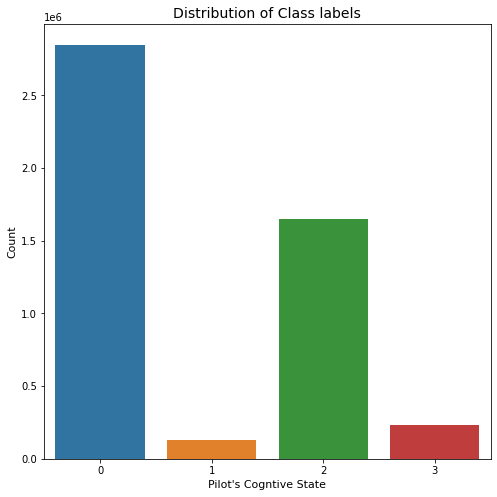

In [ ]:
#count of each label
print(train_LTB.event.value_counts())
#plot
plt.figure(figsize=(8, 8))
sns.countplot(train_LTB.event)
plt.title("Distribution of Class labels", fontsize=14)
plt.xlabel("Pilot's Cogntive State", fontsize=11)
plt.ylabel("Count", fontsize=11)
#display plot
plt.show()

0 = A(Baseline)<br>
1 = B(Surprise/Startle)<br>
2 = C(Channelized attention)<br>
3 = D(Diverted attention)

# **4 Data separation**

In [ ]:
#class labels
y = train_LTB['event']
#for MLP
dummy_y = to_categorical(y, num_classes=4)
#features
X = train_LTB.drop(['event'], axis=1)

In [ ]:
#train and cross validation split of train data.
X_train, X_cv, y_train, y_cv = train_test_split(X, dummy_y, test_size=0.2, stratify=y)

In [ ]:
print('X_train shape:', X_train.shape)
print('X_cv shape:', X_cv.shape)

X_train shape: (3893936, 23)
X_cv shape: (973485, 23)


# **5 Build Machine learning model**<br>

Here the problem is classification based so will use classification based ML algorithm to train classifier.

## **Random Forest Classifier**

**Randomized search on hyper parameters**

In [ ]:
#object of RandomForestClassifier
rf_clf = RandomForestClassifier()

In [ ]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
#parameters to pass
rf_params = {"n_estimators":[20,40,50],
              "max_depth" : [300], 
              "max_features" : ['auto'],
              "random_state" : [40],
              "class_weight": ['balanced']
              } 

#RandomizedSearchCV
rf_rscv = RandomizedSearchCV(rf_clf,param_distributions=rf_params,cv=3,n_jobs=-1, verbose=500)
rf_rscv.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 70.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 96.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 119.4min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 156.8min remaining: 44.8min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 210.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 210.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
print('best parameters:',rf_rscv.best_params_)
print('best score:', rf_rscv.best_score_)

best parameters: {'random_state': 40, 'n_estimators': 50, 'max_features': 'auto', 'max_depth': 300, 'class_weight': 'balanced'}
best score: 0.9086636241990473


**Train model with best parameters**

In [ ]:
#train with best parameters
rf_model = RandomForestClassifier(random_state= 40, n_estimators= 50, 
                                  max_features= 'auto', max_depth= 300, 
                                  class_weight= 'balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=40, verbose=0,
                       warm_start=False)

**Store and load model**

In [ ]:
#save model
joblib.dump(rf_model,'/content/rf_model.pkl')

['/content/rf_model.pkl']

In [ ]:
#copy to google drive
!cp '/content/rf_model.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/models/'

In [ ]:
#load saved model
rf_model_final = joblib.load('/content/drive/MyDrive/applied aic/case studies/rcaf/models/rf_model.pkl')

**Prediction on cross validation data**

In [ ]:
#get probabilities of cv data and log loss. 
rf_cv_predictions = rf_model_final.predict_proba(X_cv)
print(log_loss(y_cv,rf_cv_predictions))

0.12299642135951006


on cross validation data logloss is 0.12 for RandomForest Classifier.

**Prediction on actual test data with random forest classifier**

In [ ]:
#get probabilities of test data
rf_test_predictions = rf_model_final.predict_proba(test_LTB)
print(rf_test_predictions)

[[0.8  0.02 0.04 0.14]
 [0.8  0.02 0.08 0.1 ]
 [0.88 0.   0.06 0.06]
 ...
 [0.58 0.   0.4  0.02]
 [0.46 0.   0.52 0.02]
 [0.5  0.   0.48 0.02]]


**Kaggle submission**

In [ ]:
#create described submission file by kaggle.
#file must have id, A, B, C, D columns
submission_rf = pd.DataFrame(np.concatenate((np.arange(len(test_LTB))[:, np.newaxis], rf_test_predictions), 
                                         axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
submission_rf['id'] = submission_rf['id'].astype(int)

In [ ]:
submission_rf

,id,A,B,C,D
0,0,0.80,0.02,0.04,0.14
1,1,0.80,0.02,0.08,0.10
2,2,0.88,0.00,0.06,0.06
3,3,0.78,0.02,0.08,0.12
4,4,0.94,0.00,0.02,0.04
...,...,...,...,...,...
17965138,17965138,0.54,0.00,0.42,0.04
17965139,17965139,0.44,0.00,0.56,0.00
17965140,17965140,0.58,0.00,0.40,0.02
17965141,17965141,0.46,0.00,0.52,0.02


In [ ]:
#create csv file of results
submission_rf.to_csv('/content/submission_random_forest.csv', index=False)

In [ ]:
#copy results to drive
!cp '/content/submission_random_forest.csv' '/content/drive/MyDrive/applied aic/case studies/rcaf/kaggle submissions'

In [ ]:
#submit results from notebook to kaggle.
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f submission_random_forest.csv -m "This is final submission file tested on actual test data. Random forest is a classifier used. this file contains id A B C D columns as described."

100% 458M/458M [00:09<00:00, 52.2MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

**Random Forest kaggle score**<br>

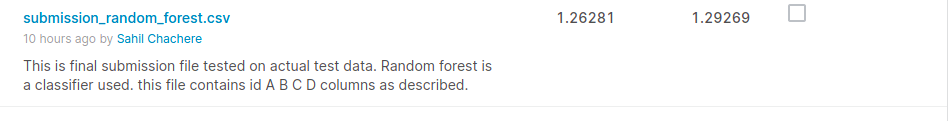

Private score - 1.26281<br>
Public score - 1.29269

## **LGBM Classifier**

**Randomized search on hyper parameters**

In [ ]:
lgbm_clf = LGBMClassifier(class_weight='balanced')

In [ ]:
#https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
lgbm_params = {'learning_rate':[0.0001, 0.001, 0.01, 0.1], 
               'n_estimators':[100],
               'max_depth':[300], 'num_leaves':list(range(60, 90, 10)),
               'min_data_in_leaf': list(range(100, 1000, 300))}

lgbm_rscv = RandomizedSearchCV(lgbm_clf, param_distributions=lgbm_params, cv=3, 
                                n_jobs=-1, verbose=100)
lgbm_rscv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 41.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 51.7min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 60.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 70.

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0....
                                            subsample=1.0,
                                            subsample_for_bin=20000

In [ ]:
print('best parameters:',lgbm_rscv.best_params_)

best parameters: {'num_leaves': 80, 'n_estimators': 100, 'min_data_in_leaf': 100, 'max_depth': 300, 'learning_rate': 0.01}


**Train model with best parameters**

In [ ]:
#train with best parameters
lgbm_model = LGBMClassifier(num_leaves=80, n_estimators=100, 
                            min_data_in_leaf=100, max_depth= 300, 
                            learning_rate=0.01)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=300,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=100, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=80, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

**Store and load model**

In [ ]:
#save model
joblib.dump(lgbm_model,'/content/lgbm_model.pkl')

['/content/lgbm_model.pkl']

In [ ]:
#copy to google drive
!cp '/content/lgbm_model.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/models/'

In [ ]:
#load saved model
lgbm_model_final = joblib.load('/content/drive/MyDrive/applied aic/case studies/rcaf/models/lgbm_model.pkl')

**Prediction on cross validation data**

In [ ]:
#get probabilities of cv data and log loss. 
lgbm_cv_predictions = lgbm_model_final.predict_proba(X_cv)
print(log_loss(y_cv,lgbm_cv_predictions))

0.7091769368624316


on cross validation data logloss is 0.70 for LightGBM Classifier.

**Prediction on actual test data with LGBM classifier**

In [ ]:
#get probabilities of test data
lgbm_test_predictions = lgbm_model_final.predict_proba(test_LTB)
print(lgbm_test_predictions)

[[0.77017342 0.0165529  0.1604437  0.05282998]
 [0.76815108 0.01650943 0.16002241 0.05531708]
 [0.77017342 0.0165529  0.1604437  0.05282998]
 ...
 [0.5156056  0.01495488 0.43832688 0.03111264]
 [0.5156056  0.01495488 0.43832688 0.03111264]
 [0.5156056  0.01495488 0.43832688 0.03111264]]


**Kaggle submission**

In [ ]:
#create described submission file by kaggle.
#file must have id, A, B, C, D columns
submission_lgbm = pd.DataFrame(np.concatenate((np.arange(len(test_LTB))[:, np.newaxis], lgbm_test_predictions), 
                                         axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
submission_lgbm['id'] = submission_lgbm['id'].astype(int)

In [ ]:
submission_lgbm

,id,A,B,C,D
0,0,0.770173,0.016553,0.160444,0.052830
1,1,0.768151,0.016509,0.160022,0.055317
2,2,0.770173,0.016553,0.160444,0.052830
3,3,0.768151,0.016509,0.160022,0.055317
4,4,0.770173,0.016553,0.160444,0.052830
...,...,...,...,...,...
17965138,17965138,0.515606,0.014955,0.438327,0.031113
17965139,17965139,0.515606,0.014955,0.438327,0.031113
17965140,17965140,0.515606,0.014955,0.438327,0.031113
17965141,17965141,0.515606,0.014955,0.438327,0.031113


In [ ]:
#create csv file of results
submission_lgbm.to_csv('/content/submission_lgbm.csv', index=False)

In [ ]:
#copy results to drive
!cp '/content/submission_lgbm.csv' '/content/drive/MyDrive/applied aic/case studies/rcaf/kaggle submissions'

In [ ]:
#submit results from notebook to kaggle.
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f submission_lgbm.csv -m "This is final submission file tested on actual test data. LGBM is a classifier used. this file contains id A B C D columns as described."

100% 1.47G/1.47G [00:33<00:00, 47.7MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

**LightGBM kaggle score**<br>

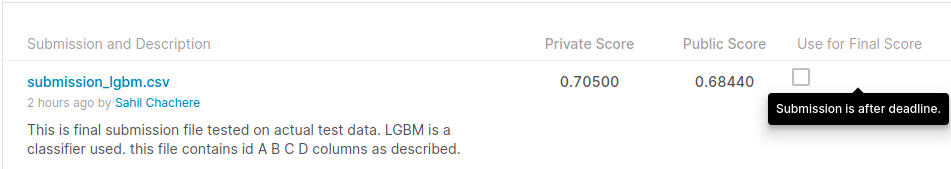

Private score - 0.70500<br>
Public score - 0.68440

## **AdaBoost Classifier**<br>

**Randomized search on hyper parameters**

In [ ]:
dt_clf = DecisionTreeClassifier(criterion='gini', max_features='auto',
                                class_weight='balanced', random_state=42)
adb_clf = AdaBoostClassifier(base_estimator=dt_clf, n_estimators=10)

In [ ]:
#https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
adb_params = {"base_estimator__max_depth":[100, 150, 300], 
              "base_estimator__min_samples_leaf":[5, 10]}

adb_rscv = RandomizedSearchCV(adb_clf, param_distributions=adb_params, cv=2, 
                                n_jobs=-1, verbose=100)
adb_rscv.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 56.3min remaining: 11.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 67.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 67.3min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight='balanced',
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features='auto',
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                 

In [ ]:
print('best parameters:',adb_rscv.best_params_)

best parameters: {'base_estimator__min_samples_leaf': 10, 'base_estimator__max_depth': 100}


**Train model with best parameters**

In [ ]:
#train with best parameters
dt_model = DecisionTreeClassifier(max_depth=100, min_samples_leaf=10)
adb_model = AdaBoostClassifier(base_estimator=dt_model, n_estimators=10)
adb_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=100,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=10,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

**Store and load model**

In [ ]:
#save model
joblib.dump(adb_model,'/content/adb_model1.pkl')

['/content/adb_model1.pkl']

In [ ]:
#copy to google drive
!cp '/content/adb_model1.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/models/'

In [ ]:
#load saved model
adb_model_final = joblib.load('/content/drive/MyDrive/applied aic/case studies/rcaf/models/adb_model1.pkl')

**Prediction on cross validation data**

In [ ]:
#get probabilities of cv data and log loss. 
adb_cv_predictions = adb_model_final.predict_proba(X_cv)
print(log_loss(y_cv,adb_cv_predictions))

0.833172010640539


**Prediction on actual test data with AdaBoost classifier**

In [ ]:
#get probabilities of test data
adb_test_predictions = adb_model_final.predict_proba(test_LTB)
print(adb_test_predictions)

[[9.99999998e-01 8.52534446e-16 1.75499492e-09 6.44007858e-13]
 [9.99997179e-01 1.94306071e-06 8.74353495e-07 3.79494546e-09]
 [9.99999974e-01 1.57946523e-14 2.63417157e-08 1.08440049e-10]
 ...
 [2.01662801e-03 4.84982383e-14 9.97983372e-01 1.47776896e-10]
 [6.70369703e-01 2.23124371e-12 3.29630295e-01 2.23620954e-09]
 [1.68386661e-02 6.44728543e-13 9.83161334e-01 4.65217397e-11]]


**Kaggle submission**

In [ ]:
#create described submission file by kaggle.
#file must have id, A, B, C, D columns
submission_adb = pd.DataFrame(np.concatenate((np.arange(len(test_LTB))[:, np.newaxis], adb_test_predictions), 
                                         axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
submission_adb['id'] = submission_adb['id'].astype(int)

In [ ]:
submission_adb

,id,A,B,C,D
0,0,1.000000,8.525344e-16,1.754995e-09,6.440079e-13
1,1,0.999997,1.943061e-06,8.743535e-07,3.794945e-09
2,2,1.000000,1.579465e-14,2.634172e-08,1.084400e-10
3,3,0.999891,7.080565e-10,1.088465e-04,1.435678e-08
4,4,1.000000,5.864654e-16,3.155414e-11,4.102717e-09
...,...,...,...,...,...
17965138,17965138,0.001159,2.624089e-14,9.988405e-01,9.013957e-13
17965139,17965139,0.929505,2.436323e-12,7.049479e-02,8.877369e-11
17965140,17965140,0.002017,4.849824e-14,9.979834e-01,1.477769e-10
17965141,17965141,0.670370,2.231244e-12,3.296303e-01,2.236210e-09


In [ ]:
#create csv file of results
submission_adb.to_csv('/content/submission_adb1.csv', index=False)

In [ ]:
#copy results to drive
!cp '/content/submission_adb1.csv' '/content/drive/MyDrive/applied aic/case studies/rcaf/kaggle submissions'

In [ ]:
#submit results from notebook to kaggle.
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f submission_adb1.csv -m "This is final submission file tested on actual test data. AdaBoost is a classifier used. this file contains id A B C D columns as described."

100% 1.56G/1.56G [00:31<00:00, 53.5MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

**Adaboost classifier kaggle score**<br>

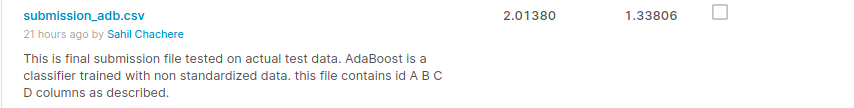

Private score - 2.01380<br>
Public score - 1.33806

## **MLP**<br>

In [ ]:
#get class weights to balance the weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y),
                                                 y)
class_weights

array([0.42714526, 9.31763555, 0.73628944, 5.17086823])

In [ ]:
class_weights_dict = {0:0.42714526, 1:9.31763555, 2:0.73628944, 3:.17086823}

In [ ]:
num_classes=4
input_shape=(23,)

#create model
model = Sequential()
# model.add(Dropout(0.5, input_shape=input_shape))
model.add((Dense(512, input_shape=input_shape, activation='relu', kernel_initializer='he_normal')))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add((Dense(256, activation='relu', kernel_initializer='he_normal')))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add((Dense(128, activation='relu', kernel_initializer='he_normal')))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
# model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# compile model and train
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=30, 
          class_weight=class_weights_dict, batch_size=250, verbose=1)

Epoch 1/30
15576/15576 [==============================] - 54s 3ms/step - loss: 0.6288 - accuracy: 0.5490 - val_loss: 0.7287 - val_accuracy: 0.7015
Epoch 2/30
15576/15576 [==============================] - 50s 3ms/step - loss: 0.4160 - accuracy: 0.6896 - val_loss: 0.6850 - val_accuracy: 0.7234
Epoch 3/30
15576/15576 [==============================] - 49s 3ms/step - loss: 0.3570 - accuracy: 0.7272 - val_loss: 0.6289 - val_accuracy: 0.7520
Epoch 4/30
15576/15576 [==============================] - 50s 3ms/step - loss: 0.3244 - accuracy: 0.7485 - val_loss: 0.6350 - val_accuracy: 0.7517
Epoch 5/30
15576/15576 [==============================] - 50s 3ms/step - loss: 0.3062 - accuracy: 0.7612 - val_loss: 0.5943 - val_accuracy: 0.7664
Epoch 6/30
15576/15576 [==============================] - 49s 3ms/step - loss: 0.2907 - accuracy: 0.7716 - val_loss: 0.5694 - val_accuracy: 0.7756
Epoch 7/30
15576/15576 [==============================] - 50s 3ms/step - loss: 0.2785 - accuracy: 0.7798 - val_loss: 0

In [ ]:
#save model
model.save("model.h5")

In [ ]:
#copy to google drive
!cp '/content/model.h5' '/content/drive/MyDrive/applied aic/case studies/rcaf/models/'

In [ ]:
#load model from disk
loaded_model = load_model('model.h5')

**Prediction on cross validation data**

In [ ]:
# #get probabilities of cv data and log loss. 
MLP_cv_predictions = loaded_model.predict_proba(X_cv)
print(log_loss(y_cv, MLP_cv_predictions))

0.4587093038799746


**Prediction on actual test data**

In [ ]:
#get probabilities of test data
MLP_test_predictions = loaded_model.predict_proba(test_LTB)
print(MLP_test_predictions)

[[9.2764199e-01 1.2552453e-04 3.5183791e-02 3.7048750e-02]
 [9.6408594e-01 6.0933088e-03 2.9183492e-02 6.3728500e-04]
 [9.2790425e-01 4.5848914e-04 3.0472806e-02 4.1164488e-02]
 ...
 [6.4715511e-01 7.1098446e-05 3.4953043e-01 3.2432796e-03]
 [4.2966405e-01 9.3176015e-05 5.6624764e-01 3.9951177e-03]
 [6.6558594e-01 6.2499057e-05 3.2979774e-01 4.5537776e-03]]


**Kaggle submission**

In [ ]:
#create described submission file by kaggle.
#file must have id, A, B, C, D columns
submission_MLP = pd.DataFrame(np.concatenate((np.arange(len(test_LTB))[:, np.newaxis], MLP_test_predictions), 
                                         axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
submission_MLP['id'] = submission_MLP['id'].astype(int)

In [ ]:
submission_MLP

,id,A,B,C,D
0,0,0.927642,1.255245e-04,0.035184,0.037049
1,1,0.964086,6.093309e-03,0.029183,0.000637
2,2,0.927904,4.584891e-04,0.030473,0.041164
3,3,0.956333,8.006345e-03,0.034792,0.000868
4,4,0.838910,8.330413e-08,0.083634,0.077456
...,...,...,...,...,...
17965138,17965138,0.661342,9.290470e-05,0.333771,0.004794
17965139,17965139,0.404585,6.052982e-05,0.591955,0.003400
17965140,17965140,0.647155,7.109845e-05,0.349530,0.003243
17965141,17965141,0.429664,9.317602e-05,0.566248,0.003995


In [ ]:
#create csv file of results
submission_MLP.to_csv('/content/submission_MLP3.csv', index=False)

In [ ]:
#copy results to drive
!cp '/content/submission_MLP2.csv' '/content/drive/MyDrive/applied aic/case studies/rcaf/kaggle submissions'

In [ ]:
#submit results from notebook to kaggle.
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f submission_MLP3.csv -m "This is final submission file tested on actual test data. MLP with keras is used. this file contains id A B C D columns as described."

100% 1.47G/1.47G [00:16<00:00, 97.2MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

**MLP kaggle score**<br>

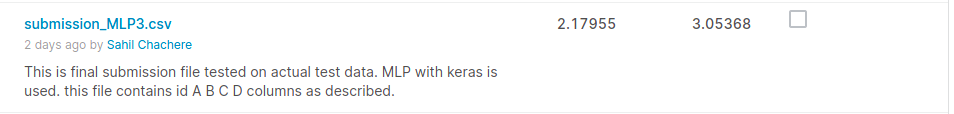



Private score - 2.17955<br>
Public score - 3.05368

## **Custom stacking ensemble model**<br>

In [4]:
#1) Split your whole into train and test(80-20)
#class labels
y = train_LTB['event']
#features
X = train_LTB.drop(['event'], axis=1)
#train test split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y)

In [4]:
print(X_train.shape, X_cv.shape)
print(y_train.shape, y_cv.shape)

(3893936, 23) (973485, 23)
(3893936,) (973485,)


In [5]:
#2) in the 80% train set, split the train set into D1 and D2.(50%-50%).
D1_X, D2_X, D1_y, D2_y = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)

In [6]:
print(D1_X.shape, D1_y.shape)

(1946968, 23) (1946968,)


In [6]:
#3 Perform sampling with replacement for Dataset D1
def generating_samples(input_data, target_data):

    #selecting rows randomly with replacement
    selecting_rows = np.sort(np.random.choice(len(input_data), size=len(input_data), replace=True))     
    #selecting columns
    selecting_columns = np.sort(np.random.choice(input_data.shape[1], size=input_data.shape[1], replace=False) )  
    #sampled rows
    sample_data = input_data[selecting_rows[:,None],selecting_columns]
    #sampled target
    target_of_sample_data = target_data[selecting_rows]
    
    return sample_data, target_of_sample_data

In [7]:
#convert dataframe to numpy array
a = pd.DataFrame(D1_X).to_numpy()
b = pd.DataFrame(D1_y).to_numpy()

In [8]:
#generate 5 samples from data
def generate_n_samples(a,b, samples=5):
  
    list_input_data =[]
    list_output_data =[]

    for i in range(samples):
        c, d = generating_samples(a, b)
        list_input_data.append(c)
        list_output_data.append(d)   
        
    return list_input_data, list_output_data

In [9]:
#lists of 5 samples generated from D1 dataset
list_input_data, list_output_data = generate_n_samples(a,b)

In [11]:
#randomsearchcv on decision tree
dt_clf = DecisionTreeClassifier(class_weight='balanced')

dt_params = {"max_depth":list(range(300, 1001, 200)),
             "min_samples_leaf":list(range(5, 21, 4)),
             "min_samples_split":list(range(10, 41, 10))
             }

dt_rscv = RandomizedSearchCV(dt_clf, dt_params, cv=3, verbose=100, n_jobs=-1)
dt_rscv.fit(list_input_data[0], list_output_data[0])

In [ ]:
print('best parameters:',dt_rscv.best_params_)

best parameters: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 700}


In [12]:
#build n base models
def build_base_learners(list_input_data, list_output_data):
    list_of_all_models = []
    for i in tqdm(range(0, len(list_input_data))):
        # all base learners are decision tree classifiers.
        model = DecisionTreeClassifier(max_depth=700, min_samples_split=10, 
                                       min_samples_leaf=5)
        model.fit(list_input_data[i], list_output_data[i])
        list_of_all_models.append(model)
        
    return list_of_all_models

In [13]:
#get all trained base learners
list_of_all_models = build_base_learners(list_input_data, list_output_data)

100%|██████████| 5/5 [13:52<00:00, 166.49s/it]


In [ ]:
#save list of models
joblib.dump(list_of_all_models, 'models_list.pkl')

['models_list.pkl']

In [ ]:
#copy to drive
!cp '/content/models_list.pkl' '/content/drive/MyDrive/applied aic/case studies/rcaf/models'

In [8]:
#load from drive
list_of_all_models = joblib.load('/content/drive/MyDrive/applied aic/case studies/rcaf/models/models_list.pkl')

In [14]:
#4 Now that we have n models- These are the base models, pass the D2 dataset to these models to get n predictions:
predictions = []
for i in list_of_all_models:
  pred = list_of_all_models[list_of_all_models.index(i)].predict(D2_X)
  predictions.append(pred)

In [15]:
predictions

[array([1, 0, 0, ..., 0, 2, 0]),
 array([1, 2, 0, ..., 0, 2, 2]),
 array([1, 0, 0, ..., 0, 2, 2]),
 array([1, 2, 0, ..., 0, 2, 2]),
 array([1, 2, 0, ..., 0, 2, 2])]

In [16]:
#create dataset from predictions
D_meta = pd.DataFrame({'m1':predictions[0], 'm2':predictions[1], 'm3':predictions[2],
                         'm4':predictions[3],'m5':predictions[4]})
D_meta

,m1,m2,m3,m4,m5
0,1,1,1,1,1
1,0,2,0,2,2
2,0,0,0,0,0
3,2,2,2,2,2
4,0,0,0,0,0
...,...,...,...,...,...
1946963,2,1,1,2,0
1946964,0,0,0,0,0
1946965,0,0,0,0,0
1946966,2,2,2,2,2


In [17]:
#train xgb with D_meta as meta classifier
xgb_model = XGBClassifier()
xgb_model.fit(D_meta, D2_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [23]:
#cross validation predicion on 20% data splitted in first step
predictions = []
for i in list_of_all_models:
  pred = list_of_all_models[list_of_all_models.index(i)].predict(X_cv)
  predictions.append(pred)

In [24]:
predictions

[array([0, 0, 0, ..., 2, 2, 2]),
 array([0, 0, 0, ..., 2, 2, 2]),
 array([0, 0, 0, ..., 2, 2, 2]),
 array([0, 0, 0, ..., 2, 2, 2]),
 array([0, 0, 0, ..., 2, 2, 2])]

In [34]:
D_cv_meta = pd.DataFrame({'m1':predictions[0], 'm2':predictions[1], 'm3':predictions[2],
                         'm4':predictions[3],'m5':predictions[4]})
D_cv_meta

,m1,m2,m3,m4,m5
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,2,2,2,2,2
...,...,...,...,...,...
973480,2,2,2,2,2
973481,2,2,2,2,2
973482,2,2,2,2,2
973483,2,2,2,2,2


In [35]:
pred_cv = xgb_model.predict_proba(D_cv_meta)
pred_cv

array([[9.9408793e-01, 9.5012382e-04, 3.3785063e-03, 1.5834650e-03],
       [9.9408793e-01, 9.5012382e-04, 3.3785063e-03, 1.5834650e-03],
       [9.9408793e-01, 9.5012382e-04, 3.3785063e-03, 1.5834650e-03],
       ...,
       [3.6265515e-03, 3.3394652e-04, 9.9562681e-01, 4.1262622e-04],
       [3.6265515e-03, 3.3394652e-04, 9.9562681e-01, 4.1262622e-04],
       [3.6265515e-03, 3.3394652e-04, 9.9562681e-01, 4.1262622e-04]],
      dtype=float32)

In [18]:
#actual test data prediction
predictions = []
for i in list_of_all_models:
  pred = list_of_all_models[list_of_all_models.index(i)].predict(test_LTB)
  predictions.append(pred)

In [19]:
D_test_meta = pd.DataFrame({'m1':predictions[0], 'm2':predictions[1], 'm3':predictions[2],
                         'm4':predictions[3],'m5':predictions[4]})
D_test_meta

,m1,m2,m3,m4,m5
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,3,0,0
...,...,...,...,...,...
17965138,2,0,2,2,2
17965139,2,0,2,2,2
17965140,2,0,0,2,2
17965141,2,0,0,2,2


In [20]:
pred_test = xgb_model.predict_proba(D_test_meta)
pred_test

array([[9.9463344e-01, 9.6474122e-04, 3.0257779e-03, 1.3760935e-03],
       [9.9463344e-01, 9.6474122e-04, 3.0257779e-03, 1.3760935e-03],
       [9.9463344e-01, 9.6474122e-04, 3.0257779e-03, 1.3760935e-03],
       ...,
       [1.8332691e-01, 4.4195377e-03, 8.0890369e-01, 3.3498511e-03],
       [1.8332691e-01, 4.4195377e-03, 8.0890369e-01, 3.3498511e-03],
       [1.8332691e-01, 4.4195377e-03, 8.0890369e-01, 3.3498511e-03]],
      dtype=float32)

**kaggle submission**

In [21]:
submission_stacking = pd.DataFrame(np.concatenate((np.arange(len(test_LTB))[:, np.newaxis], pred_test), 
                                         axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
submission_stacking['id'] = submission_stacking['id'].astype(int)

In [22]:
submission_stacking

,id,A,B,C,D
0,0,0.994633,0.000965,0.003026,0.001376
1,1,0.994633,0.000965,0.003026,0.001376
2,2,0.994633,0.000965,0.003026,0.001376
3,3,0.994633,0.000965,0.003026,0.001376
4,4,0.942485,0.003057,0.009231,0.045227
...,...,...,...,...,...
17965138,17965138,0.025699,0.001470,0.971816,0.001015
17965139,17965139,0.025699,0.001470,0.971816,0.001015
17965140,17965140,0.183327,0.004420,0.808904,0.003350
17965141,17965141,0.183327,0.004420,0.808904,0.003350


In [23]:
#create csv file of results
submission_stacking.to_csv('/content/submission_stacking.csv', index=False)

In [ ]:
#copy results to drive
!cp '/content/submission_stacking.csv' '/content/drive/MyDrive/applied aic/case studies/rcaf/kaggle submissions'

In [26]:
#submit results from notebook to kaggle.
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f submission_stacking.csv -m "This is final submission file tested on actual test data. custom stacking model is used. this file contains id A B C D columns as described."

100% 1.54G/1.54G [01:25<00:00, 19.4MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

**Custom stacking algorithm kaggle score**<br>

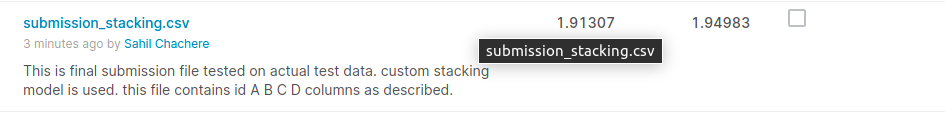


Private score - 1.91307<br>
Public score - 1.94983